In [1]:
using Dates
using MarketData
using StatsBase
using Plots
using DataFrames
using Statistics
using MarketTechnicals
include("Chapter 14 Snippets.jl")


(process:2268): GLib-GIO-WARNING **: 18:59:11.896: Unexpectedly, UWP app `30008NitroOfficeDVDApp.NebulaeBookReader_2.1.3.0_x86__k9060n443y9rm' (AUMId `30008NitroOfficeDVDApp.NebulaeBookReader_k9060n443y9rm!App') supports 15 extensions but has no verbs


computeDrawDownsTimeUnderWater

# Data
We import bitcoin data from Yahoo finance from 2021.

In [2]:
btc = yahoo("BTC-USD", YahooOpt(period1 = DateTime(2021, 1, 1), period2 = DateTime(2021, 12, 1)))["Close"]

335×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-01 to 2021-12-01
│            │ Close      │
├────────────┼────────────┤
│ 2021-01-01 │ 29374.1523 │
│ 2021-01-02 │ 32127.2676 │
│ 2021-01-03 │ 32782.0234 │
│ 2021-01-04 │ 31971.9141 │
│ 2021-01-05 │ 33992.4297 │
│ 2021-01-06 │ 36824.3633 │
│ 2021-01-07 │ 39371.043  │
│ 2021-01-08 │ 40797.6094 │
│ 2021-01-09 │ 40254.5469 │
   ⋮
│ 2021-11-24 │ 56280.4258 │
│ 2021-11-25 │ 57274.6797 │
│ 2021-11-26 │ 53569.7656 │
│ 2021-11-27 │ 54815.0781 │
│ 2021-11-28 │ 57248.457  │
│ 2021-11-29 │ 57806.5664 │
│ 2021-11-30 │ 57005.4258 │
│ 2021-12-01 │ 57229.8281 │

In [3]:
using MarketTechnicals
btc_df = DataFrame(btc[55:end])
btc_df[!, "EMA 55"] = ema(values(btc), 55)[1:end]
btc_df[!, "EMA 15"] = ema(values(btc), 15)[55 - 15 + 1: end]
btc_df[!, :Cross] .= 0
btc_df[!, :Cross] = ifelse.(btc_df[:, "EMA 55"] .< btc_df[:, "EMA 15"], 1, 0)
btc_df[!, :Signal] = [0; diff(btc_df.Cross)]
btc_df = btc_df[2:end, :]
btc_df[!, :Return] = values(percentchange(btc[55:end]))
btc_ts = TimeArray(btc_df, timestamp = :timestamp)

280×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-02-25 to 2021-12-01
│            │ Close      │ EMA 55     │ EMA 15     │ Cross │ Signal │ Return  │
├────────────┼────────────┼────────────┼────────────┼───────┼────────┼─────────┤
│ 2021-02-25 │ 47093.8516 │ 40068.2385 │ 49537.9107 │ 1.0   │ 0.0    │ -0.0525 │
│ 2021-02-26 │ 46339.7617 │ 40292.2215 │ 49138.1421 │ 1.0   │ 0.0    │ -0.016  │
│ 2021-02-27 │ 46188.4531 │ 40502.8012 │ 48769.431  │ 1.0   │ 0.0    │ -0.0033 │
│ 2021-02-28 │ 45137.7695 │ 40668.3358 │ 48315.4733 │ 1.0   │ 0.0    │ -0.0227 │
│ 2021-03-01 │ 49631.2422 │ 40988.4396 │ 48479.9444 │ 1.0   │ 0.0    │ 0.0996  │
│ 2021-03-02 │ 48378.9883 │ 41252.3877 │ 48467.3249 │ 1.0   │ 0.0    │ -0.0252 │
│ 2021-03-03 │ 50538.2422 │ 41584.0254 │ 48726.1896 │ 1.0   │ 0.0    │ 0.0446  │
│ 2021-03-04 │ 48561.168  │ 41833.2091 │ 48705.5619 │ 1.0   │ 0.0    │ -0.0391 │
│ 2021-03-05 │ 48927.3047 │ 42086.5696 │ 48733.2797 │ 1.0   │ 0.0    │ 0.0075  │
   ⋮
│ 2021-11-24 │ 56280.4258 │ 

In [5]:
targetPositions = btc_ts.Cross
returns = btc_ts.Return
print()

# Bet timing
We derive the bet timing when positions flatten or flip.

In [23]:
betTiming(targetPositions)

4-element Vector{Date}:
 2021-05-13
 2021-09-26
 2021-11-30
 2021-12-01

# Holding Period 
Derives avgerage holding period (in days) using avg entry time pairing algo

In [7]:
holding, mean = holdingPeriod(targetPositions)
holding

3×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-05-13 to 2021-11-30
│            │ dT    │ w     │
├────────────┼───────┼───────┤
│ 2021-05-13 │ 77.0  │ 1.0   │
│ 2021-09-26 │ 58.0  │ 1.0   │
│ 2021-11-30 │ 58.0  │ 1.0   │

In [8]:
mean

64.33333333333333

#  HHI concentration
Derives the algorithm for deriving hhi concentration

In [9]:
positiveReturnsConcentration, negativeReturnsConcentration, 
        monthlyReturnsConcentration = hhiConcentration(returns)

(0.005233561373351357, 0.006029499264795561, 0.018165816326530592)

# Compute Draw Downs And Time Under Water
Computes series of drawdowns and the time under water associated with them

In [10]:
drawDowns, timeUnderWater = computeDrawDownsTimeUnderWater(btc, true)
drawDowns

12×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-03 to 2021-11-08
│            │ DrawDowns  │
├────────────┼────────────┤
│ 2021-01-03 │ 810.1094   │
│ 2021-01-08 │ 10365.0625 │
│ 2021-02-09 │ 1562.9219  │
│ 2021-02-11 │ 803.8164   │
│ 2021-02-14 │ 772.2305   │
│ 2021-02-17 │ 469.2109   │
│ 2021-02-21 │ 12402.1758 │
│ 2021-03-11 │ 473.0312   │
│ 2021-03-13 │ 9538.9258  │
│ 2021-04-13 │ 33696.1094 │
│ 2021-10-20 │ 7510.4492  │
│ 2021-11-08 │ 13997.0625 │

In [11]:
timeUnderWater

11×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-03 to 2021-10-20
│            │ timeUnderWater │
├────────────┼────────────────┤
│ 2021-01-03 │ 0.0137         │
│ 2021-01-08 │ 0.0876         │
│ 2021-02-09 │ 0.0055         │
│ 2021-02-11 │ 0.0082         │
│ 2021-02-14 │ 0.0082         │
│ 2021-02-17 │ 0.011          │
│ 2021-02-21 │ 0.0493         │
│ 2021-03-11 │ 0.0055         │
│ 2021-03-13 │ 0.0849         │
│ 2021-04-13 │ 0.5202         │
│ 2021-10-20 │ 0.052          │

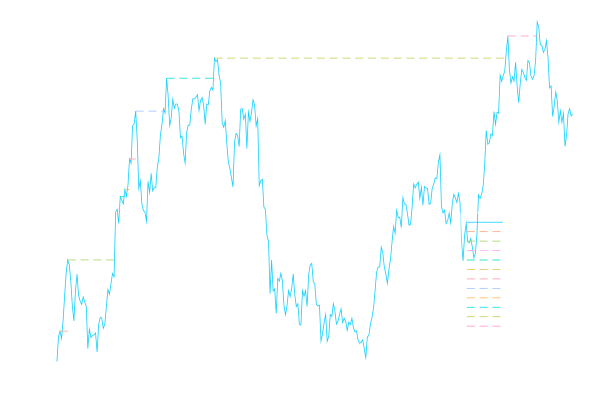

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [22]:
p = plot(btc, label = "BTC", background = :transparent, 
        legend = :bottomright, legendfont=font(5), legendfontcolor = :white) 
for i in 1:length(drawDowns)-1
    plot!(p, [timestamp(drawDowns)[i]; timestamp(drawDowns)[i+1]], [values(btc[timestamp(drawDowns)])[i]; values(btc[timestamp(drawDowns)])[i]], label = "Draw Down $i", linestyle=:dash, 
            background = :transparent, legendfontcolor = :white)
end
display(p)